In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

In [2]:
class DoublePendulum:
    def __init__(self,init_state = [120, 0, -20, 0],
                 l1=1.0,  # length of rod 1, 1m
                 l2=1.0,  # length of rod 2, 1m
                 m1=1.0,  # mass of ball 1, 1kg
                 m2=1.0,  # mass of ball 2, 1kg
                 g=9.81,  # gravity on Earth, 9.81m/s^2
                 origin=(0, 0)): #initial conditions
        #theta1=120 angle position of arm1
        #omega1=0 velocity of arm 1
        #theta2=-20 angle position of arm 2
        #omega2=0 velocity of arm 2
        self.init_state = np.asarray(init_state, dtype='float')
        self.params = (l1, l2, m1, m2, g)
        self.origin = origin
        self.time_elapsed = 0
        self.state = self.init_state * np.pi / 180. #converting between degrees to rads
    
    def position(self):#x2 and y2 positionns 
        (l1, l2, m1, m2, g) = self.params
        #x=(Cumulative sum of originx + l1 * sin(theta1) + l2 sin(theta2)) AKA where ball 2 is on x axis
        x = np.cumsum([self.origin[0], l1 * sin(self.state[0]), l2 * sin(self.state[2])])
        #y=(Cumulative sum of originy + l1 * cos(theta1) + l2 cos(theta2)) AKA where ball 2 is on y axis
        y = np.cumsum([self.origin[1], -l1 * cos(self.state[0]), -l2 * cos(self.state[2])])
        #return the coordinates of ball 2
        return (x, y)

    def E(self):#energy of the currennt state
        (l1, l2, m1, m2, g) = self.params
        #position x2
        x = np.cumsum([l1 * sin(self.state[0]), l2 * sin(self.state[2])]) 
        #position y2
        y = np.cumsum([-l1 * cos(self.state[0]), -l2 * cos(self.state[2])]) 
        #velocity x direction
         #x=(Cumulative sum of l1 * theta1 * cos(theta1) + l2 * theta2 * cos(theta2)
        vx = np.cumsum([l1 * self.state[1] * cos(self.state[0]), l2 * self.state[3] * cos(self.state[2])]) 
        #velocity y direction
        #y=(Cumulative sum of l1 * theta1 * sin(theta1) + l2 * theta2 * sin(theta2)
        vy = np.cumsum([l1 * self.state[1] * sin(self.state[0]), l2 * self.state[3] * sin(self.state[2])])
        
        #potential energy
        U = g * (m1 * y[0] + m2 * y[1])
        #kinetic energy
        K = (m1 * np.dot(vx, vx) + m2 * np.dot(vy, vy))/2
        #return the total energy of the system
        return K + U

    def update(self, state, t):
        #deriving equations for current state
        (l1, l2, m1, m2, g) = self.params
        dydx = np.zeros_like(state) #creates empty array with shape and type of input
        
        #∆cos
        cosd = cos(state[2] - state[0])
        #∆sin
        sind = sin(state[2] - state[0])

        #initial
        dydx[0] = state[1] 
        #deriv1
        dydx[1] = (m2 * l1 * state[1] * state[1] * sind * cosd + m2 * g * sin(state[2]) * cosd + m2 * l2 * state[3] * state[3] * sind - (m1 + m2) * g * sin(state[0])) / ((m1 + m2) * l1 - m2 * l1 * cosd * cosd)
        #deriv2
        dydx[2] = state[3]
        #deriv3
        dydx[3] = (-m2 * l2 * state[3] * state[3] * sind * cosd + (m1 + m2) * g * sin(state[0]) * cosd - (m1 + m2) * l1 * state[1] * state[1] * sind - (m1 + m2) * g * sin(state[2])) / ((l2 / l1) * ((m1 + m2) * l1 - m2 * l1 * cosd * cosd))
        return dydx

    def step(self, dt):
        #update state by time step
        self.state = integrate.odeint(self.update, self.state, [0, dt])[1]
        self.time_elapsed += dt

In [3]:
pendulum = DoublePendulum([120., 0.0, -20., 0.0])
fps=50
dt = 1./fps

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


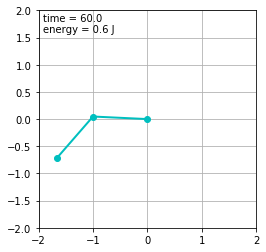

total run time= 60.0 seconds


In [4]:
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'co-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    #start animation
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    #do animation
    global pendulum, dt
    pendulum.step(dt)
    line.set_data(*pendulum.position())
    time_text.set_text('time = %.1f' % pendulum.time_elapsed)
    energy_text.set_text('energy = %.1f J' % pendulum.E())
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)
frames=3000
totaltime=frames/fps


ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=True, init_func=init)


ani.save('double_pendulum_earth.gif', fps=50)

plt.show()
print('total run time=',totaltime,'seconds')